# Exploring Clusters

## Overview
This ticket covers manual exploration of the ticket clustering output. One of the important steps of topic modeling is taking a deep dive into the output clusters to do a sanity check and ensure that the resulting topics are sensible. Some of the important fields to look at will be the title, description, and any other fields that could give a sense of good clustering (like do all the issues in this cluster have the same label, for example).

This exploration can also help us determine whether we need to increase/decrease the number of clusters in the algorithm. If a large cluster exists with more than one clear topic/focus then increasing the number of topics could split those up into more coherent clusters.

## Deliverables
A new Jupyter notebook containing the exploration that shows the different ticket clusters, highlights some really good or really poor examples, and recommends any modifications to the clustering step (like adding/removing clusters)

## Imports

In [68]:
!pip install gap-stat
!pip install yellowbrick --user
!pip install OpenEnsembles

    100% |████████████████████████████████| 1.6MB 6.1MB/s ta 0:00:01


In [230]:
import re

from it_topic_naming import ITTopicNamer
import pandas as pd
import numpy as np
from sklearn_pandas import DataFrameMapper
from sklearn.cluster import KMeans
from sklearn import metrics, pipeline, preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from gap_statistic import OptimalK
from yellowbrick.cluster import KElbowVisualizer
import networkx as nx
from networkxgmml import XGMMLReader
from collections import defaultdict
import openensembles as oe

# Import Data

## ```repo_graph```

In [143]:
def get_repo_graph(filename):
    with open(filename, "rb") as graph_file:
        return XGMMLReader(graph_file) 

repo_graph = get_repo_graph("data/12_02_graph.xgmml")

In [144]:
print(nx.info(repo_graph))

Name: 
Type: DiGraph
Number of nodes: 9566
Number of edges: 28250
Average in degree:   2.9532
Average out degree:   2.9532


## ```repo_df```

In [49]:
repo_df = pd.read_pickle("data/all_repo_df")

In [50]:
repo_df.head()

,label,name,owner,repo_id,url,closed_date,created_date,description,id,number,status,title,updated_date,body,# of Comments,Average Length of Comments,label_names,issue_duration
issue_id,,,,,,,,,,,,,,,,,,
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643,Default-Label,ready,kelektiv,d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93,https://github.com/kelektiv/node-cron,2010-12-03 22:31:59-05:00,2010-11-19 00:13:24-05:00,"On Mac OS X (at least 10.6.4+), there's no nee...",427508,1,closed,Mac OS X support for compilation,2014-07-17 10:50:53-04:00,"This doesn't work for me (Linux), but I'll add...",24.0,9.33333,[none],14 days 22:18:35
issues/6036d01e-bee1-5a3c-a423-37db00e22778,Default-Label,ready,kelektiv,d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93,https://github.com/kelektiv/node-cron,2012-09-25 21:11:53-04:00,2012-09-23 00:59:59-04:00,Updated the readme.md file to reflect the need...,7064741,108,closed,Updated readme.md to reflect requirements for ...,2012-09-25 21:11:53-04:00,"Please collapse these commits into one. , Yep,...",4.0,11.75,[none],2 days 20:11:54
issues/f8aefd85-8c03-519e-82dc-cca0388363b4,Default-Label,ready,kelektiv,d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93,https://github.com/kelektiv/node-cron,2012-11-04 03:27:49-05:00,2012-10-02 00:58:27-04:00,This should make the version requirement for w...,7280739,116,closed,updated readme for 64bit windows install,2014-06-18 13:41:07-04:00,,1.0,1,[none],33 days 03:29:22
issues/fce88d5c-2e92-560b-a9cb-1d9dfdc9249a,Default-Label,ready,kelektiv,d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93,https://github.com/kelektiv/node-cron,2013-04-28 22:06:45-04:00,2013-04-27 20:28:46-04:00,Support for domains so that async method will ...,13725651,162,closed,Add support for domains,2013-04-28 22:06:45-04:00,Bind to domain doesn't need to be exposed. But...,3.0,35.3333,[none],1 days 01:37:59
issues/d45a91b7-8c5d-5343-8cc7-4cbea8e818ff,Default-Label,ready,kelektiv,d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93,https://github.com/kelektiv/node-cron,2013-04-29 14:11:53-04:00,2013-04-28 22:07:06-04:00,Support for domains so that async method will ...,13741381,163,closed,support for domains,2014-07-29 01:20:13-04:00,@ncb000gt Looks good to you? LGTM. There is a...,6.0,51.6667,[none],0 days 16:04:47


In [140]:
repo_df["combined_text"]= repo_df["description"]+", "+repo_df["title"]+", "+repo_df["body"]

## Get adjacency matrix

In [147]:
def create_adjacency_df(repo_graph, node_types):
    adj_df = nx.to_pandas_adjacency(repo_graph)
    adj_df = adj_df.loc[[idx for idx in adj_df.index if "issue" in idx]]
    adj_df.index.name = "issue_id"
    adj_df = adj_df[[col for col in adj_df.columns if col.split("/")[0] in node_types]]
    for index in adj_df.index:
        adj_df.at[index, index] = 1
    return adj_df

## Get files changes df

In [256]:
## get commits
from RepoClusters import get_commits_df
from pydriller import RepositoryMining

In [249]:
commits_df=get_commits_df(repo_graph)

In [258]:
url = "https://github.com/kelektiv/node.bcrypt.js"
hash_to_commits = {commit.hash: commit 
                   for commit in RepositoryMining(url, only_no_merge=True).traverse_commits()}
hash_to_mods = {commit.hash: commit.modifications 
                for commit in RepositoryMining(url, only_no_merge=True).traverse_commits()}

In [251]:
def get_changed_filenames(commit_hash):
    try:
        return [mod.filename for mod in hash_to_mods[commit_hash] if commit_hash in hash_to_mods]
    except KeyError: 
        pass

In [259]:
commits_df["files_changed"]=commits_df["hash"].apply(lambda commit_hash: get_changed_filenames(commit_hash))

In [262]:
import itertools
joined_commits = pd.DataFrame(commits_df.groupby("issue_id").agg({"files_changed": lambda bodies: list(itertools.chain.from_iterable(filter(None, bodies))) }))

In [264]:
repo_df=repo_df.merge(joined_commits, on="issue_id", how="left")

In [271]:
for row in repo_df.loc[repo_df["files_changed"].isna(), "files_changed"].index:
    repo_df.at[row, "files_changed"] = []

# Features & Vectorization

## Full Feature List
- Label Names
- Number of Comments
- Status
- Description: Length 
- Description: Number of Headers
- Description: Number of URLs
- Description: Number of Code Blocks
- Description: TFIDF
- Title: Length
- Title: TFIDF
- Comment Bodies: Number of Headers
- Comment Bodies: Number of URLs
- Comment Bodies: Number of Code Blocks
- Comment Bodies: TDIDF
- Combined Description, Title, Comment Body: TDIDF
- Adjacency Matrix: Connection to pull_request, other issues, commits
- files_changed_df: if an issue has a commit, the files changes from the commit will be reflected in the matrix

## Feature Functions

In [148]:
def count(series):
    return np.array([len(item) for item in series]).reshape(-1, 1)

def body_length(series):
    return np.array([len(str(item[0]).split()) for item in series]).reshape(-1, 1)

def num_headers(series):
    return np.array([len(re.findall("##", str(item))) for item in series]).reshape(-1, 1)

def num_urls(series):
    return np.array([len(re.findall("https://", str(item))) for item in series]).reshape(-1, 1)

def num_code_blocks(series):
    return np.array([len(re.findall("{code}", str(item))) for item in series]).reshape(-1, 1)    

In [ ]:
    (['description'], [preprocessing.FunctionTransformer(body_length, validate=False),
                      preprocessing.MinMaxScaler()], {'alias': "Description Length"}),
    ('description', [preprocessing.FunctionTransformer(num_headers, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Num Headers"}),
    ('description', [preprocessing.FunctionTransformer(num_urls, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Num URLs"}),
    ('description', [preprocessing.FunctionTransformer(num_code_blocks, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Num Code Blocks"}),
    ('description', [CountVectorizer(min_df=2, max_df=0.95), 
                     TfidfTransformer()], {"alias": "Tfidf_description"}),
    ('title', [CountVectorizer(max_df=0.95), 
               TfidfTransformer()], {"alias": "Tfidf_title"}),
    (['title'], [preprocessing.FunctionTransformer(body_length, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Title Length"}),
    ('body', [CountVectorizer(max_df=0.95), 
               TfidfTransformer()], {"alias": "Tfidf_comment_body"}),
    ('body', [preprocessing.FunctionTransformer(num_headers, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Num Headers: Comment"}),
    ('body', [preprocessing.FunctionTransformer(num_urls, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Num URLs: Comment"}),
    ('body', [preprocessing.FunctionTransformer(num_code_blocks, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Num Code Blocks: Comment"}),

## Selecting the features with DataFrameMapper

In [503]:
mapper = DataFrameMapper([
    ('label_names', preprocessing.MultiLabelBinarizer()),
    ('files_changed',preprocessing.MultiLabelBinarizer()),
    ('# of Comments', [preprocessing.FunctionTransformer(reshape_array, validate=False),
                      preprocessing.MinMaxScaler()], {'alias': "Num Comments"}),
    (['status'], preprocessing.OneHotEncoder()),
    ('combined_text', [CountVectorizer(max_df=0.95), 
               TfidfTransformer()], {"alias": "Tfidf_combined_text"}),
    ('combined_text', [preprocessing.FunctionTransformer(num_headers, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Num Headers: combined_text"}),
    ('combined_text', [preprocessing.FunctionTransformer(num_urls, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Num URLs: combined_text"}),
    ('combined_text', [preprocessing.FunctionTransformer(num_code_blocks, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Num Code Blocks: combined_text"}),
], df_out=True)

In [504]:
repo_ids = list(repo_df.groupby("repo_id").groups.keys())

In [505]:
vectors_df = mapper.fit_transform(repo_df.groupby("repo_id").get_group(repo_ids[1]))

In [506]:
vectors_df

,label_names_bug,label_names_cleanup,label_names_feature,label_names_in progress,label_names_napi,label_names_none,label_names_question,label_names_windows,files_changed_.editorconfig,files_changed_.travis.yml,...,Tfidf_combined_text_你可以用第二个方法,Tfidf_combined_text_同时后面的插入等操作也没有运行,Tfidf_combined_text_在保存数据前对密码加盐加密,Tfidf_combined_text_我想使用bcrypt,Tfidf_combined_text_无法识别的命令行选项,Tfidf_combined_text_错误,Tfidf_combined_text_시경,Num Headers: combined_text,Num URLs: combined_text,Num Code Blocks: combined_text
issue_id,,,,,,,,,,,,,,,,,,,,,
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
issues/6036d01e-bee1-5a3c-a423-37db00e22778,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
issues/f8aefd85-8c03-519e-82dc-cca0388363b4,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
issues/fce88d5c-2e92-560b-a9cb-1d9dfdc9249a,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.027778,0.010846,0.0
issues/d45a91b7-8c5d-5343-8cc7-4cbea8e818ff,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
issues/057db976-df8d-5a60-bb9c-af70319976b2,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
issues/2d9d9160-f858-5491-a370-1e7c9b5c1a03,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.004338,0.0
issues/c181f2ba-33eb-5aa5-8372-2cdda4689a3c,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.398694,0.000000,0.004338,0.0


## Combine ```vectors_df```,```adj_matrix```, and ```files_changed_df```

In [507]:
node_types =["pull_requests", "issues", "commits"]
adj_matrix = create_adjacency_df(repo_graph, node_types)

In [508]:
vectors_df=vectors_df.merge(adj_matrix, on="issue_id", how="left")

In [509]:
vectors_df.shape

(768, 19529)

In [308]:
from RepoClusters import RepoClusters
repoClusters = RepoClusters("data/12_02_graph.xgmml")
repoClusters.vectorize().cluster(k=5)
repo_ids = repoClusters.get_repo_ids()
repoClusters.get_clustered_repo_df(repo_ids[0])

/home/jovyan/work/experiments/Experiment with Ticket Clustering/RepoClusters.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,label,name,owner,repo_id,url,closed_date,created_date,description,id,number,status,title,updated_date,body,# of Comments,Average Length of Comments,label_names,issue_duration,cluster_id
issue_id,,,,,,,,,,,,,,,,,,,
issues/87b2f454-d7ef-5a61-bf2f-002c62a05111,Default-Label,ready,kelektiv,82668c86-65fa-4bec-a9ad-3e3143df8ccb,https://github.com/kelektiv/node-cron,2010-09-17 02:34:40-04:00,2010-09-16 19:18:52-04:00,"Hi, I just added exports.CronTime = CronTime s...",319973,1,closed,Accessing CronTime,2010-09-16 19:34:40-04:00,Looks like a good addition to me. Thanks!,2.0,4.5,[none],0 days 07:15:48,3
issues/d76660ed-d1df-548b-a40f-4aec1ff0b11c,Default-Label,ready,kelektiv,82668c86-65fa-4bec-a9ad-3e3143df8ccb,https://github.com/kelektiv/node-cron,2011-09-25 17:20:05-04:00,2011-09-23 03:53:51-04:00,,1720332,10,closed,Primarily Calculate cron time vs setInterval,2014-07-23 03:33:57-04:00,"This looks great. However, I don't see any ad...",8.0,67.25,[none],2 days 13:26:14,1
issues/f092a337-12d7-5844-b4ce-1e0157f56f86,Default-Label,ready,kelektiv,82668c86-65fa-4bec-a9ad-3e3143df8ccb,https://github.com/kelektiv/node-cron,2014-10-14 19:41:33-04:00,2014-09-29 20:33:49-04:00,This fix issue #112.,44352506,114,closed,Exec commands for onTick & onComplete,2014-10-14 20:45:48-04:00,Sorry this took so long. I thought I'd looked ...,4.0,8.25,[none],14 days 23:07:44,2
issues/206aceef-033b-5aaa-a764-b6f2d0aceb48,Default-Label,ready,kelektiv,82668c86-65fa-4bec-a9ad-3e3143df8ccb,https://github.com/kelektiv/node-cron,2014-11-11 02:35:46-05:00,2014-10-12 02:50:54-04:00,"Hi, The `_getNextDateFrom` function entered a...",45568234,118,closed,Updated _getNextDateFrom to handle an edge cas...,2014-11-11 02:35:46-05:00,"So, the real issue there had to do with the se...",2.0,21.5,[none],30 days 00:44:52,1
issues/f06118f2-8b20-57de-b471-b8681d83c1f9,Default-Label,ready,kelektiv,82668c86-65fa-4bec-a9ad-3e3143df8ccb,https://github.com/kelektiv/node-cron,2014-11-11 04:00:37-05:00,2014-11-08 06:15:50-05:00,For compatibility with Node 0.11.x and Windows...,48157238,122,closed,Replace the time module with moment-timezone,2014-11-11 12:47:47-05:00,"@ncb000gt removed in commit `98dad71`, Altho...",8.0,15.625,[none],2 days 21:44:47,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
issues/6c7e0ca4-4802-547f-ab72-530cf765dabe,Default-Label,ready,kelektiv,82668c86-65fa-4bec-a9ad-3e3143df8ccb,https://github.com/kelektiv/node-cron,2019-08-25 09:48:34-04:00,2019-08-25 09:42:29-04:00,I don't know how to run it every x seconds.,484911300,436,closed,Sorry to ask: where is the documentation?,2019-08-25 09:48:34-04:00,,0.0,,[none],0 days 00:06:05,3
issues/8cbe0d77-b705-5ef9-a870-4e5600828ed8,Default-Label,ready,kelektiv,82668c86-65fa-4bec-a9ad-3e3143df8ccb,https://github.com/kelektiv/node-cron,2019-09-07 13:59:36-04:00,2019-09-07 08:06:01-04:00,When installing on latest version of moleculer...,490607104,437,closed,npm WARN moleculer-cron@0.0.2 requires a peer ...,2019-09-07 13:59:36-04:00,I updated the dependencies in this package and...,1.0,47,[none],0 days 05:53:35,4
issues/56122d45-3b22-503e-a10a-ce13afd4bb9d,Default-Label,ready,kelektiv,82668c86-65fa-4bec-a9ad-3e3143df8ccb,https://github.com/kelektiv/node-cron,,2019-09-25 21:41:51-04:00,The API documentation hasn't changed much sinc...,498538247,441,open,Rework the API Documentation so that it's more...,2019-10-11 12:50:19-04:00,"Would love to create PR for this, That would b...",5.0,14.4,[Hacktoberfest],,0


# Determine the # of Clusters

In [342]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import decomposition

In [346]:
kmeans_model = KMeans(random_state=0)
hierarchical_model = AgglomerativeClustering(affinity='euclidean', linkage='ward')
##skipped knn does not do well with high dimensionality

models = [kmeans_model, hierarchical_model, pca_model]

def elbow_method(model, df, metric, k_range):
    visualizer = KElbowVisualizer(model, k=k_range, metric=metric, timings=False)
    visualizer.fit(df)    
    visualizer.poof()

## Silhouette  Method

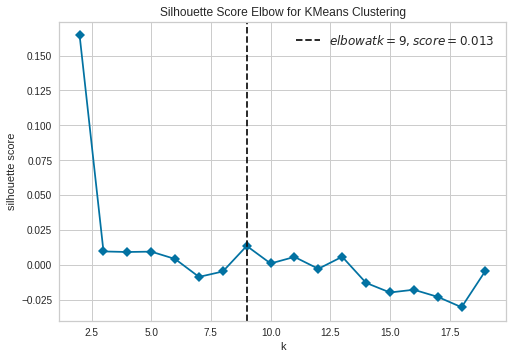

/home/jovyan/.local/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/jovyan/.local/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/jovyan/.local/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


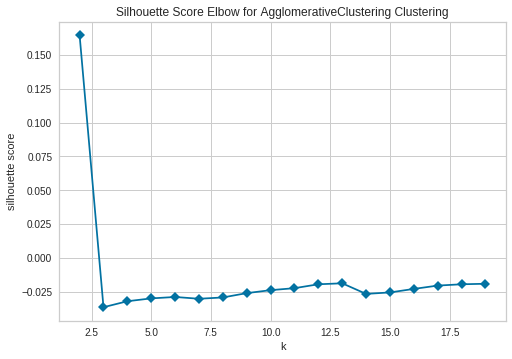

YellowbrickTypeError: The supplied model is not a clustering estimator; try a classifier or regression score visualizer instead!

In [345]:
for model in models: 
    elbow_method(model, vectors_df, "silhouette", (2,20))

## Elbow Method

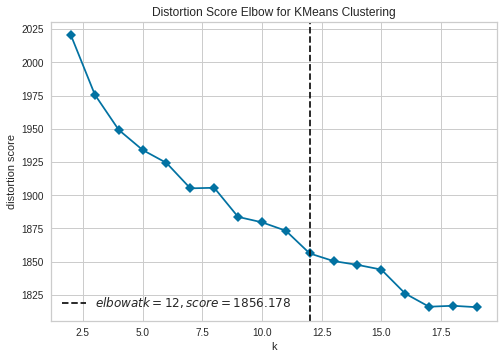

In [336]:
elbow_method(model, vectors_df, "distortion", (2,20))

## Gap Statistic

In [219]:
def optimalK(data, nrefs, maxClusters):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [289]:
k, gapdf = optimalK(vectors_df, nrefs=5, maxClusters=20)
print ('Optimal k is: '+str( k))

Optimal k is: 18


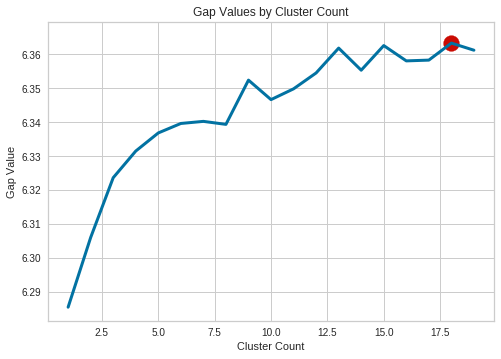

In [290]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

# Decide n_cluster & run kmeans

In [291]:
kmeans = KMeans(n_clusters=6, random_state=1).fit(vectors_df)
preds = kmeans.predict(vectors_df)

# Add topic name to clusters

In [292]:
def get_topic_names(preds, col):
    print("Example "+str(col))
    print(repo_df.loc[vectors_df.index[0]][col])
    print(82 * '_')
    
    tid_to_descriptions = defaultdict(list)
    for idx, pred in enumerate(preds):
        tid_to_descriptions[pred].append(repo_df.loc[vectors_df.index[idx]][col])
    
    print("Cluster Counts")
    {print(str(tid) +": "+str(len(descriptions))) for tid, descriptions in tid_to_descriptions.items()}
    print(82 * "_")
    
    topic_namer = ITTopicNamer(tid_to_descriptions, num_top_keyphrases=3, topic_name_min_df=1)
    topic_names = topic_namer.get_all_topic_names()
    print("Topic Names")
    for key,value in topic_names.items():
        print(str(key)+": "+ str(value))
    print(82 * "_")

### Topic names for descriptions only

In [293]:
get_topic_names(preds, "description")

Example description
On Mac OS X (at least 10.6.4+), there's no need for libbsd for arc4random. I've basically added an exception in wscript and in bcrypt.cc to avoid the dependency and include for random.h on OS X, which makes it compile successfully. 
__________________________________________________________________________________
Cluster Counts
6: 97
2: 218
5: 35
1: 23
9: 68
8: 7
7: 16
10: 43
14: 5
13: 87
3: 48
0: 27
11: 25
12: 58
4: 11
__________________________________________________________________________________
Topic Names
6: Gyp Verb Check Python Version Using, Gyp Verb Check Python Version, Verb Check Python Version Using
2: Build Type Release Gyp Verb, Gyp Verb Build Type Release, Verb Build Type Release Gyp
5: Build Error Gyp Err! Stack, Instantiation of Function Template Specialization, Function Call, Expected Single Argument
1: Npm Owner Ls Bcrypt Error, Error Npm Owner Ls Bcrypt, Likely Additional Logging Output Above. Npm
9: Npm Error Log for Lines Telling, Correct D

### Topic names for title, desciptions, and comment body

In [294]:
get_topic_names(preds, "combined_text")

Example combined_text
On Mac OS X (at least 10.6.4+), there's no need for libbsd for arc4random. I've basically added an exception in wscript and in bcrypt.cc to avoid the dependency and include for random.h on OS X, which makes it compile successfully. , Mac OS X support for compilation, This doesn't work for me (Linux), but I'll add in some conditionals. Thanks for the changes. :) , Aw :( Can't understand why not, it seemed like it would literally only target OS X. Oh well, sorry about that! , I tried this on my home machine and it worked fine. I suspect I blew something up on my laptop when I tried it then. I pulled and pushed the code into master. Can you try it once more to make sure master works for you? If so I'll push 0.1.1 to npm. :)  Thanks for the contribution! , Works great! Can't wait to drop the copy we have in our repository :-D , Perfect. Will publish when I get home. , Ah, one more thing. I really appreciate the mention in the README, but `Salazar Cardozo' is actually 

Using files_changed as a label for the cluster, produce metrics based on the quality of data. 

# Visualize Clusters

In [226]:
def get_cluster_graph(kmeans,vectors_df):
    # Visualize the results on PCA-reduced data

    reduced_data = PCA(n_components=2).fit_transform(vectors_df)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
    plt.title('K-means clustering (PCA-reduced data)\n'
          'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

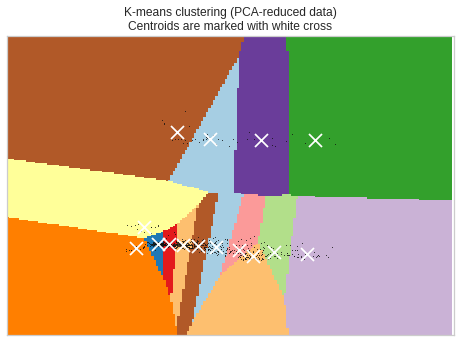

In [295]:
get_cluster_graph(kmeans, vectors_df)

# Cluster Statistics

In [510]:
from sklearn import metrics
from sklearn import datasets
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

def cluster_stats_sil(k, X):
    method_names = ['K-means', 'Affinity', 'Spectral', 'Agglomerative']
    df=pd.DataFrame(index=method_names)
    df.index.names = ['Methods']
    for i in range(2,int(k)):
        algorithms = []
        algorithms.append(KMeans(n_clusters=i, random_state=1))
        algorithms.append(AffinityPropagation())
        algorithms.append(SpectralClustering(n_clusters=i, random_state=1,
                                     affinity='nearest_neighbors'))
        algorithms.append(AgglomerativeClustering(n_clusters=i))
        
        data=[]
        for algo in algorithms:
            algo.fit(X)
            data.append(({
                str(i) : metrics.silhouette_score(X, algo.labels_, metric='euclidean',
                                      sample_size=300)}))
        
        results = pd.DataFrame(data=data, columns=[str(i)], index=method_names)
        results.index.names = ['Methods']
        df = df.merge(results, on="Methods", how="left")
        
    return df

In [511]:
cluster_df_sil=cluster_stats_sil(15, vectors_df)

In [512]:
cluster_df_sil

,2,3,4,5,6,7,8,9,10,11,12,13,14
Methods,,,,,,,,,,,,,
K-means,0.151390,0.003564,0.009766,-0.013670,0.012327,0.015671,0.005847,0.003009,-0.012177,-0.012147,0.006866,-0.003212,0.011210
Affinity,0.010185,0.015099,0.007608,0.003285,0.010576,0.008527,0.002301,0.005770,0.009360,0.011279,0.002409,0.010543,0.000730
Spectral,0.172948,-0.029398,0.003837,0.025533,-0.005805,0.023432,-0.013852,-0.004280,-0.023479,-0.015047,-0.014228,-0.016874,-0.023373
Agglomerative,0.155938,-0.039372,-0.038473,-0.018562,-0.021766,-0.036046,-0.042189,-0.035539,-0.024390,-0.015822,-0.016551,-0.013100,-0.021201


In [513]:
cluster_melt_sil = cluster_df_sil.stack().reset_index()
cluster_melt_sil.columns = ["Methods", "K Level", "Silhouette Score"]

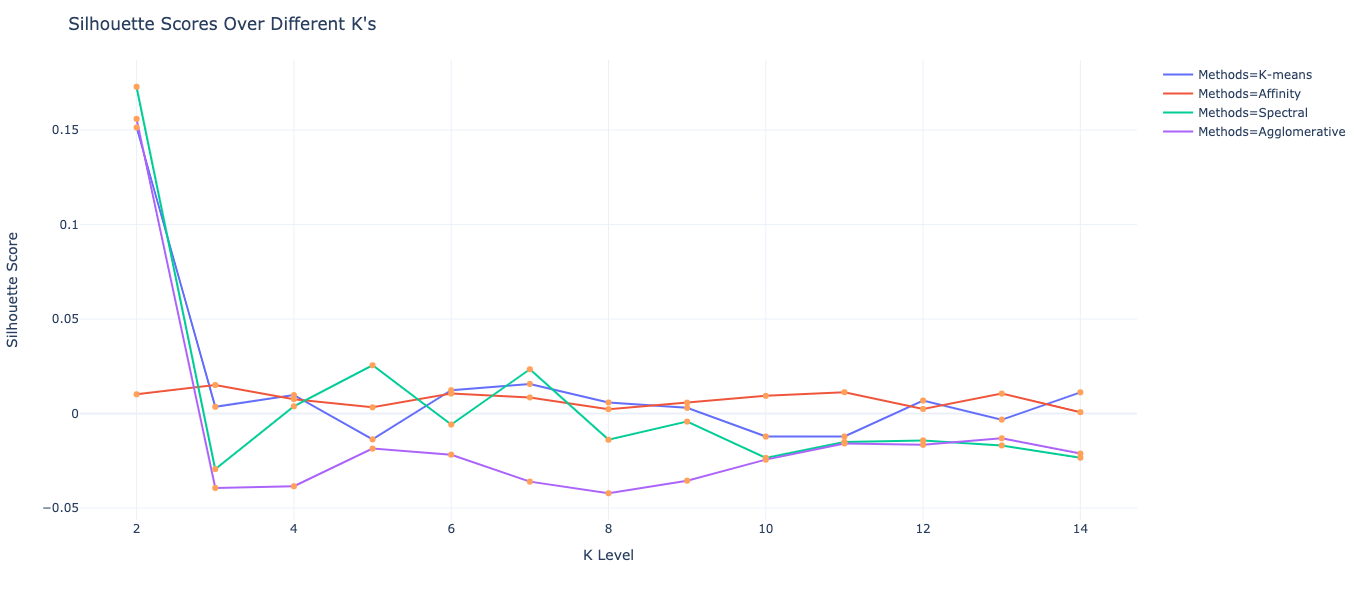

In [514]:
import plotly.graph_objects as go
import plotly.express as px

fig = px.line(cluster_melt_sil, x="K Level", y="Silhouette Score", color="Methods", hover_name="Methods", template="plotly_white")
fig.add_trace(go.Scatter(x=cluster_melt_sil["K Level"], 
                         y=cluster_melt_sil["Silhouette Score"],
                         mode='markers',
                         showlegend=False))
fig.update_layout(
    title=dict(
        text="Silhouette Scores Over Different K's",
        xanchor="auto")
)

fig.show()

In [433]:
def cluster_stats_sse(k, X):
    method_names = ['K-means']
    df=pd.DataFrame(index=method_names)
    df.index.names = ['Methods']
    for i in range(2,int(k)):
        algorithms = []
        algorithms.append(KMeans(n_clusters=i, random_state=1))
        data=[]
        for algo in algorithms:
            algo.fit(X)
            data.append(({
                str(i) : algo.inertia_}))
        
        results = pd.DataFrame(data=data, columns=[str(i)], index=method_names)
        results.index.names = ['Methods']
        df = df.merge(results, on="Methods", how="left")
        
    return df

In [434]:
cluster_df_sse=cluster_stats_sse(16, vectors_df)

In [435]:
cluster_df_sse

,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Methods,,,,,,,,,,,,,,
K-means,2020.22462,1975.614816,1961.998748,1943.293145,1934.659025,1917.076095,1901.966049,1887.914226,1882.719878,1871.208641,1866.441945,1859.764283,1852.432628,1846.034712


In [447]:
cluster_melt_sse = cluster_df_sse.stack().reset_index()
cluster_melt_sse.columns = ["Methods", "K Level", "SSE"]

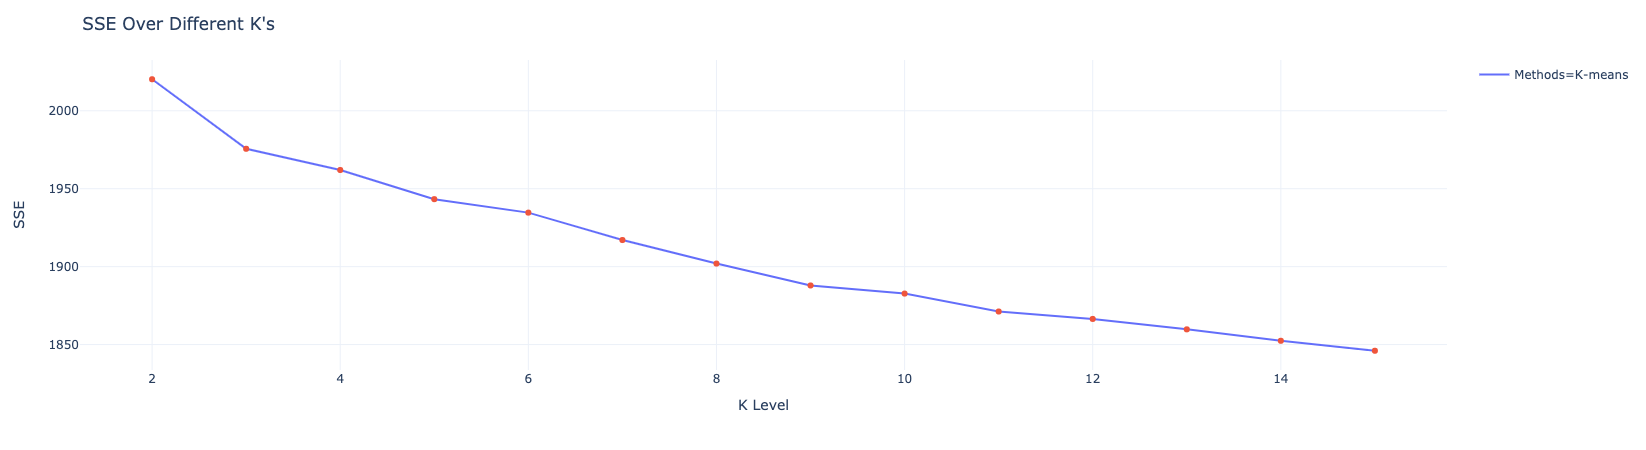

In [449]:
fig = px.line(cluster_melt_sse, x="K Level", y="SSE", color="Methods", hover_name="Methods", template="plotly_white")
fig.add_trace(go.Scatter(x=cluster_melt_sse["K Level"], 
                         y=cluster_melt_sse["SSE"],
                         mode='markers',
                         showlegend=False))

fig.update_layout(
    title=dict(
        text="SSE Over Different K's",
        xanchor="auto")
)

fig.show()

In [515]:
i=5
kmeans = KMeans(n_clusters=i, random_state=1)
affinity =AffinityPropagation()
spectral=SpectralClustering(n_clusters=i, random_state=1,
                                     affinity='nearest_neighbors')
algo = AgglomerativeClustering(n_clusters=i)

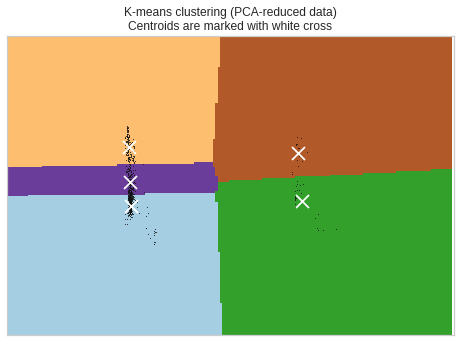

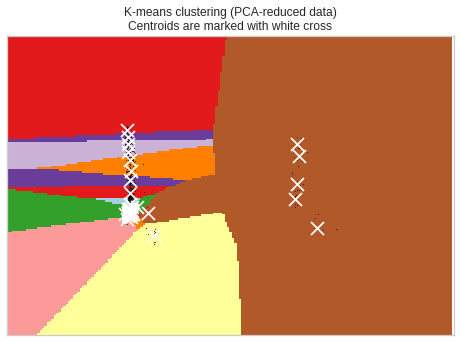

In [516]:
methods = [kmeans, affinity]
for method in methods: 
    get_cluster_graph(method, vectors_df)

In [468]:
preds = spectral.fit_predict(vectors_df) 

In [469]:
get_topic_names(preds, "combined_text")

Example combined_text
On Mac OS X (at least 10.6.4+), there's no need for libbsd for arc4random. I've basically added an exception in wscript and in bcrypt.cc to avoid the dependency and include for random.h on OS X, which makes it compile successfully. , Mac OS X support for compilation, This doesn't work for me (Linux), but I'll add in some conditionals. Thanks for the changes. :) , Aw :( Can't understand why not, it seemed like it would literally only target OS X. Oh well, sorry about that! , I tried this on my home machine and it worked fine. I suspect I blew something up on my laptop when I tried it then. I pulled and pushed the code into master. Can you try it once more to make sure master works for you? If so I'll push 0.1.1 to npm. :)  Thanks for the contribution! , Works great! Can't wait to drop the copy we have in our repository :-D , Perfect. Will publish when I get home. , Ah, one more thing. I really appreciate the mention in the README, but `Salazar Cardozo' is actually 

In [473]:
single_repo =repo_df.groupby("repo_id").get_group(repo_ids[1])

In [475]:
single_repo["cluster_id"] = preds

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [494]:
df = single_repo.groupby("cluster_id").get_group(4)["description"]

for i,desc in enumerate(df):
    print(df.index[i])
    print(52*"-")
    print(desc)
    print(52* " ")

issues/0de9d4ae-5399-52bd-b39f-b951a7186f95
----------------------------------------------------
Seems like some Node 8 issues were fixed in #527 but they have not been published to npm yet.
                                                    
issues/2382e3eb-4ab4-599f-9ceb-b82572136e73
----------------------------------------------------
The readme says:  > Per bcrypt implementation, only the first 72 characters of a string are used. Any extra characters are ignored when matching passwords.  However, isn't it actually the first 72 **bytes** that are used? If the string is UTF-8 encoded and has e.g. emojis, it could potentially be truncated before 72 characters.
                                                    
issues/288cb084-6365-58e3-b392-888a5f9174e2
----------------------------------------------------
I tried to hash a password async and providing a string such as 'hello' to be the salt, and this is the returned error:  Invalid Salt. Salt must be in the form of: $Ver$logs(NumRo